In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import xgboost as xgb
import optuna
import shap
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
# Fechas para el análisis histórico
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=5*365) # 5 años de datos

# Parámetros de la simulación
num_portfolios = 25000

tickers_acciones = ["AAPL", "MSFT", "GOOGL", "NVDA", "AMZN", "COST", "WMT", "MCD", "JPM", "BAC", "V", "JNJ", "PFE", "UNH", "CAT", "BA", "XOM", "CVX", "SQM", "BHP"]
ticker_etf_mercado = 'SPY' # Usaremos el S&P 500 como proxy del mercado
ticker_bono_fred = 'DGS10' # Tasa del Tesoro de EEUU a 10 años


In [3]:
df = pd.read_csv("../data/procesado/data_procesado.csv")
df

,fecha,ticker,precio_cierre,retorno_diario,tasa_bono,volumen
0,2020-10-05 00:00:00,AAPL,113.321625,0.000000,0.0078,106243800
1,2020-10-05 00:00:00,AMZN,159.960007,0.000000,0.0078,75506000
2,2020-10-05 00:00:00,BA,171.199997,0.000000,0.0078,19082100
3,2020-10-05 00:00:00,BAC,21.796659,0.000000,0.0078,44396800
4,2020-10-05 00:00:00,BHP,33.512653,0.000000,0.0078,1701342
...,...,...,...,...,...,...
26350,2025-10-02 00:00:00,SQM,44.619999,0.025511,0.0410,1284300
26351,2025-10-02 00:00:00,UNH,353.720001,0.015561,0.0410,8564200
26352,2025-10-02 00:00:00,V,345.950012,-0.005405,0.0410,5198000
26353,2025-10-02 00:00:00,WMT,101.699997,-0.002550,0.0410,15605400


In [4]:
tasa_libre_riesgo = df["tasa_bono"].iloc[-1]
tasa_libre_riesgo

np.float64(0.041)

In [5]:
print("--- Paso 1: Pivotando el DataFrame a formato 'ancho' ---")
# La optimización de portafolio necesita una columna por cada activo
df_retornos_wide = df.pivot(index='fecha', columns='ticker', values='retorno_diario')

# Calculamos los insumos para la Teoría Moderna de Portafolios
retornos_medios_anual = df_retornos_wide.mean() * 252
matriz_cov_anual = df_retornos_wide.cov() * 252

print("Datos preparados para la optimización.")


--- Paso 1: Pivotando el DataFrame a formato 'ancho' ---
Datos preparados para la optimización.


In [6]:
def calcular_max_drawdown(retornos_serie):
    """Calcula la máxima caída (Max Drawdown) de una serie de retornos."""
    retorno_acumulado = (1 + retornos_serie).cumprod()
    pico_anterior = retorno_acumulado.cummax()
    drawdown = (retorno_acumulado - pico_anterior) / pico_anterior
    return drawdown.min()

print(f"\nEjecutando simulación de Monte Carlo con {num_portfolios} portafolios...")

resultados = []
pesos_portafolios = []
num_activos = len(df_retornos_wide.columns)

for i in range(num_portfolios):
    pesos = np.random.random(num_activos)
    pesos /= np.sum(pesos)
    pesos_portafolios.append(pesos)

    retorno = np.sum(retornos_medios_anual * pesos)
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov_anual, pesos)))
    
    sharpe = (retorno - tasa_libre_riesgo) / volatilidad
    
    retornos_port_diarios = (df_retornos_wide * pesos).sum(axis=1)
    retornos_negativos_diarios = retornos_port_diarios[retornos_port_diarios < 0]
    volatilidad_negativa = retornos_negativos_diarios.std() * np.sqrt(252)
    sortino = (retorno - tasa_libre_riesgo) / volatilidad_negativa if volatilidad_negativa > 0 else 0
    
    max_drawdown = calcular_max_drawdown(retornos_port_diarios)
    calmar = retorno / abs(max_drawdown) if max_drawdown < 0 else 0
    
    var_95 = np.percentile(retornos_port_diarios, 5)
    
    resultados.append([retorno, volatilidad, sharpe, sortino, calmar, var_95])

df_simulacion = pd.DataFrame(resultados, columns=['retorno', 'volatilidad', 'sharpe', 'sortino', 'calmar', 'var_95'])
df_pesos = pd.DataFrame(pesos_portafolios, columns=df_retornos_wide.columns)
df_simulacion = pd.concat([df_simulacion, df_pesos], axis=1)

# Identificar portafolios óptimos
max_sortino_port = df_simulacion.loc[df_simulacion['sortino'].idxmax()]
min_vol_port = df_simulacion.loc[df_simulacion['volatilidad'].idxmin()]

print("\n--- Portafolio de Mínima Volatilidad ---")
print(min_vol_port.tail(num_activos).sort_values(ascending=False).head())
print(f"\n--- Portafolio de Máximo Ratio de Sortino ---")
print(max_sortino_port.tail(num_activos).sort_values(ascending=False).head())




Ejecutando simulación de Monte Carlo con 25000 portafolios...

--- Portafolio de Mínima Volatilidad ---
XOM     0.121551
WMT     0.106063
JNJ     0.096541
AAPL    0.096040
UNH     0.078203
Name: 15040, dtype: float64

--- Portafolio de Máximo Ratio de Sortino ---
NVDA    0.123196
XOM     0.105298
JPM     0.098630
WMT     0.087187
PFE     0.086305
Name: 7839, dtype: float64


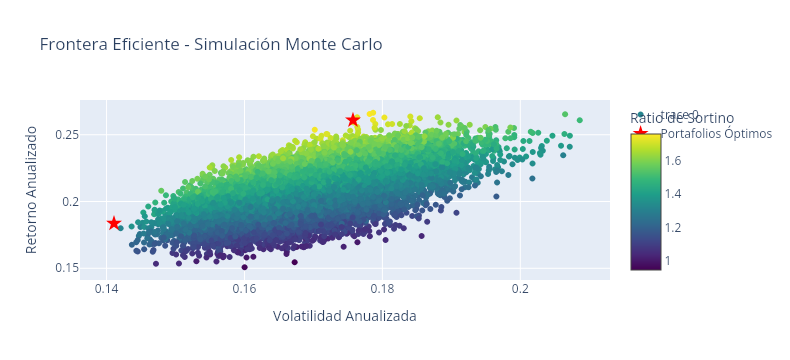

In [7]:
# =============================================================================
# FASE 4: VISUALIZACIÓN DE LA FRONTERA EFICIENTE CON PLOTLY
# =============================================================================
fig = go.Figure()

# Añadir todos los portafolios simulados
fig.add_trace(go.Scatter(
    x=df_simulacion['volatilidad'],
    y=df_simulacion['retorno'],
    mode='markers',
    marker=dict(
        color=df_simulacion['sortino'],
        showscale=True,
        colorscale='Viridis',
        colorbar=dict(title='Ratio de Sortino')
    ),
    text=[f"Sortino: {s:.2f}" for s in df_simulacion['sortino']] # Tooltip
))

# Marcar los portafolios óptimos
fig.add_trace(go.Scatter(
    x=[min_vol_port['volatilidad'], max_sortino_port['volatilidad']],
    y=[min_vol_port['retorno'], max_sortino_port['retorno']],
    mode='markers',
    marker=dict(color='red', size=12, symbol='star'),
    name='Portafolios Óptimos'
))

fig.update_layout(
    title='Frontera Eficiente - Simulación Monte Carlo',
    xaxis_title='Volatilidad Anualizada',
    yaxis_title='Retorno Anualizado',
    showlegend=True
)
fig.show()



In [8]:

# =============================================================================
# FASE 5: MACHINE LEARNING PARA PREDECIR VOLATILIDAD
# =============================================================================
print("\n--- Preparando datos para el modelo de ML (predicción de volatilidad) ---")
# Usaremos 'SPY' como proxy del mercado
df_spy = df[df['ticker'] == 'SPY'].set_index('fecha').sort_index()

# 1. Feature Engineering (X)
df_ml = pd.DataFrame(index=df_spy.index)
df_ml['volatilidad_pasada_21d'] = df_spy['retorno_diario'].rolling(window=21).std().shift(1)
df_ml['retorno_pasado_21d'] = df_spy['retorno_diario'].rolling(window=21).mean().shift(1)
df_ml['volumen_pasado_21d'] = df_spy['volumen'].rolling(window=21).mean().shift(1)

# 2. Creación del Target (y)
# El objetivo es predecir la volatilidad realizada en los próximos 21 días (1 mes)
df_ml['volatilidad_futura_21d'] = df_spy['retorno_diario'].rolling(window=21).std().shift(-21)

df_ml = df_ml.dropna()

# 3. Separación y División de Datos
X = df_ml.drop('volatilidad_futura_21d', axis=1)
y = df_ml['volatilidad_futura_21d']

# Usamos shuffle=False por ser datos de series de tiempo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Datos de ML listos. Entrenando con {len(X_train)} muestras.")




--- Preparando datos para el modelo de ML (predicción de volatilidad) ---
Datos de ML listos. Entrenando con 970 muestras.


In [9]:
# =============================================================================
# FASE 6: OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA
# =============================================================================
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'tree_method': 'hist',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    }
    model = xgb.XGBRegressor(**params)
    
    # Usamos cross-validation para una evaluación robusta
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return np.mean(score) # Optuna maximiza, y un error menos negativo es mejor

study = optuna.create_study(direction='maximize')
print("\nIniciando búsqueda con Optuna... (puede tardar unos minutos)")
study.optimize(objective, n_trials=50, timeout=300)

print(f"\nMejor puntaje (neg_mse): {study.best_value:.4f}")
print(f"Mejores parámetros: {study.best_params}")


[I 2025-10-03 17:56:13,935] A new study created in memory with name: no-name-4ab1e154-597f-43bb-beda-a56e649189df



Iniciando búsqueda con Optuna... (puede tardar unos minutos)


[I 2025-10-03 17:56:15,462] Trial 0 finished with value: -1.534214814963218e-05 and parameters: {'max_depth': 7, 'learning_rate': 0.08410354494351789, 'n_estimators': 400, 'subsample': 0.6750634918415883, 'colsample_bytree': 0.7156955350992223}. Best is trial 0 with value: -1.534214814963218e-05.
[I 2025-10-03 17:56:18,843] Trial 1 finished with value: -1.9589446878453087e-05 and parameters: {'max_depth': 5, 'learning_rate': 0.14494585712151384, 'n_estimators': 250, 'subsample': 0.802926432128259, 'colsample_bytree': 0.6307765712778338}. Best is trial 0 with value: -1.534214814963218e-05.
[I 2025-10-03 17:56:19,387] Trial 2 finished with value: -1.5050214458171936e-05 and parameters: {'max_depth': 8, 'learning_rate': 0.015028352238522445, 'n_estimators': 300, 'subsample': 0.8282736566920609, 'colsample_bytree': 0.6944348705882628}. Best is trial 2 with value: -1.5050214458171936e-05.
[I 2025-10-03 17:56:19,632] Trial 3 finished with value: -1.5216044836747697e-05 and parameters: {'max_


Mejor puntaje (neg_mse): -0.0000
Mejores parámetros: {'max_depth': 3, 'learning_rate': 0.010723244397141557, 'n_estimators': 500, 'subsample': 0.7288333692663678, 'colsample_bytree': 0.8303309662259263}



--- Evaluando el modelo de ML final ---
RMSE en el conjunto de prueba: 0.006093

--- Generando explicaciones con SHAP ---


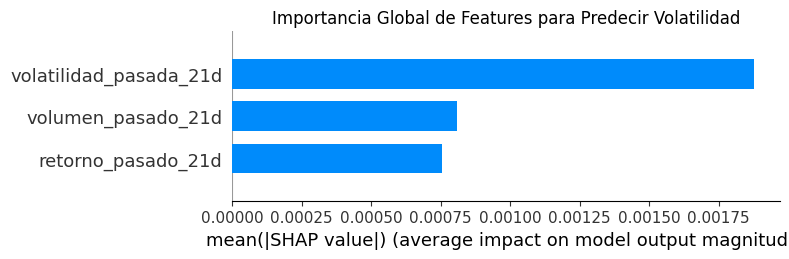

In [10]:
# =============================================================================
# FASE 7: EVALUACIÓN Y EXPLICABILIDAD DEL MODELO ML (SHAP)
# =============================================================================
final_ml_model = xgb.XGBRegressor(**study.best_params)
final_ml_model.fit(X_train, y_train)

print("\n--- Evaluando el modelo de ML final ---")
predictions = final_ml_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.6f}")

print("\n--- Generando explicaciones con SHAP ---")
explainer = shap.TreeExplainer(final_ml_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title("Importancia Global de Features para Predecir Volatilidad")
plt.tight_layout()
plt.show()



In [11]:
# =============================================================================
# FASE 8: APLICACIÓN Y CONCLUSIÓN
# =============================================================================
ultimas_features = X.tail(1)
volatilidad_predicha = final_ml_model.predict(ultimas_features)[0]
volatilidad_media_historica = y.mean()

print("\n--- 🤖 Recomendación Estratégica Final ---")
print(f"La volatilidad predicha para el próximo mes es: {volatilidad_predicha:.6f}")
print(f"La volatilidad media histórica es: {volatilidad_media_historica:.6f}")

if volatilidad_predicha > volatilidad_media_historica:
    print("\nSe predice un período de ALTA VOLATILIDAD.")
    print("Recomendación: Adoptar una postura defensiva. Considerar el portafolio de MÍNIMA VOLATILIDAD:")
    print(min_vol_port.tail(num_activos).sort_values(ascending=False).head())
else:
    print("\nSe predice un período de BAJA A MODERADA VOLATILIDAD.")
    print("Recomendación: Adoptar una postura orientada al retorno. Considerar el portafolio de MÁXIMO RATIO DE SORTINO:")
    print(max_sortino_port.tail(num_activos).sort_values(ascending=False).head())



--- 🤖 Recomendación Estratégica Final ---
La volatilidad predicha para el próximo mes es: 0.007386
La volatilidad media histórica es: 0.009816

Se predice un período de BAJA A MODERADA VOLATILIDAD.
Recomendación: Adoptar una postura orientada al retorno. Considerar el portafolio de MÁXIMO RATIO DE SORTINO:
NVDA    0.123196
XOM     0.105298
JPM     0.098630
WMT     0.087187
PFE     0.086305
Name: 7839, dtype: float64
